In [2]:
%load_ext autoreload
%autoreload 2

from utils import *
from models import *
from baselines import *

import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.spatial import KDTree

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [452]:
epoch = 19
model_name = "joint_wwm"
dataset = "retail"
model_path = "../models/" + "_".join([model_name, dataset, str(epoch)])
validation_split = .2

In [419]:
menu_dataset_wholeseq  = MenuDataset("retail_price.csv", "retail_vocab_v2.p", sampling="wholeseq", encoding="ISO-8859-1", item_column_name="Description", factor_column_name="Country", price_column_name="UnitPrice")

In [420]:
train_loader_wholeseq, valid_loader_wholeseq = create_data_loader(menu_dataset_wholeseq, validation_split)

In [63]:
def load_model(model_name, model_path, hidden_dimension):
    
    model = None
    
    if model_name == "joint_wwm":

        model = WWM(1, vocab=menu_dataset_wholeseq.vocab, nb_lstm_units=128, embedding_dim=128, n_factors=menu_dataset_wholeseq.n_factors, batch_size=256)
    
    elif model_name == "word2vec":
        
        model = wp(menu_dataset_wholeseq.n_vocab, hidden_dimension, menu_dataset_wholeseq.n_vocab)
    
    elif model_name == "wp":
        
        model = wp(menu_dataset_wholeseq.n_vocab, hidden_dimension, 1)
    
    elif model_name == "mwp":
        
        model = mwp(menu_dataset_wholeseq.n_vocab, hidden_dimension)
    
    elif model_name == "mwcp":
        
        model = mwcp(menu_dataset_wholeseq.n_vocab, menu_dataset_wholeseq.n_factors, hidden_dimension)
        
    model.load_state_dict(torch.load(model_path))
    
    return model

In [453]:
model = load_model(model_name, model_path, 128)
model.eval()

WWM(
  (word_embedding): Embedding(1001, 128, padding_idx=0)
  (lstm): LSTM(128, 128, batch_first=True)
  (rnn): RNN(128, 128, batch_first=True)
  (drop_out): Dropout(p=0.2, inplace=False)
  (Wm): Linear(in_features=128, out_features=1001, bias=True)
  (Wy): Linear(in_features=128, out_features=1, bias=True)
)

In [424]:
filtered_words = ['<PAD>']
n_filtered_words = len(filtered_words)
filtered_words_idx = [menu_dataset_wholeseq.top_words.index(word) for word in filtered_words]
all_words = [word for word in menu_dataset_wholeseq.top_words if word not in filtered_words]

In [425]:
len(all_words)

1000

In [454]:
if model_name == "joint_wwm":
    X_param = model.word_embedding.weight
    Wc_param = model.Wc
elif model_name == "word2vec" or model_name == "wp" or model_name == "mwp":
    X_param = model.linear1.weight
    X_param = X_param.transpose(0,1)
elif model_name == "mwcp":
    X_param = model.linear1_word.weight
    X_param = X_param.transpose(0,1)

In [427]:
X_param.shape

torch.Size([1001, 128])

In [348]:
Wc_param.shape

torch.Size([15, 128, 128])

In [428]:
word_price_avg = pickle.load(open("../params/retail_word_avg_price.p", "rb"))

In [429]:
# subsample words
n_subsample_words = 1000
# overlap_words = set(word_price_avg.keys()).intersection(set(all_words))
# print (len(overlap_words))
subsample_words = random.sample(all_words, k=n_subsample_words)

print (len(subsample_words))

1000


In [455]:
X = []
for word in subsample_words:
    i = menu_dataset_wholeseq.top_words.index(word)
    tmp = []
    for j in range(X_param.shape[1]):
        tmp.append(float(X_param[i][j]))
    X.append(tmp)
        
X = np.asarray(X)  

In [324]:
Wc = []
for factor in menu_dataset_wholeseq.all_factors:
    i = menu_dataset_wholeseq.all_factors.index(factor)
    tmp = []
    for j in range(Wc_param.shape[1]):
        tmpp = []
        for k in range(Wc_param.shape[2]):
            tmpp.append(float(Wc_param[i][j][k]))
        tmp.append(tmpp)
    Wc.append(tmp)
    
Wc = np.asarray(Wc)
print (Wc.shape)

(15, 128, 128)


In [431]:
word_prices = pickle.load(open("../params/retail_word_prices.p", "rb"))

In [456]:
tree = KDTree(X)

[Text(0, 0, 'homemade'),
 Text(0, 0, 'scarf'),
 Text(0, 0, 'badge'),
 Text(0, 0, 'please'),
 Text(0, 0, 'glamorous'),
 Text(0, 0, 'school'),
 Text(0, 0, 'romantic'),
 Text(0, 0, 'boudoir'),
 Text(0, 0, 'gingerbread'),
 Text(0, 0, 'battery'),
 Text(0, 0, 'etched')]

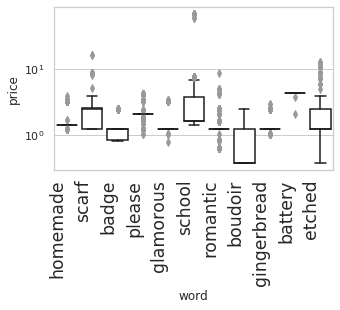

In [457]:
word = "homemade"
i = subsample_words.index(word)
k = 10
nearest_indices = tree.query(X[i], k+1)[1]
nearest_indices = nearest_indices[1:]

nearest_words = [subsample_words[j] for j in nearest_indices]

rows = []
for price in word_prices[word]:
    rows.append([word, price])

for word in nearest_words:
    for price in word_prices[word]:
        rows.append([word, price])
        
df_for_boxplot = pd.DataFrame(rows, columns = ['word', 'price'])

sns.set(style="whitegrid")
plt.figure(figsize=(5,3))
# plt.ylim(1, 100)
ax = sns.boxplot(x="word", y="price", data=df_for_boxplot, color='white')
plt.setp(ax.artists, edgecolor = 'k', facecolor='w')
plt.setp(ax.lines, color='k')

ax.set_yscale("log")
ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'
)

In [236]:
model_name = "word2vec"
dataset = "shoe"

if dataset == "retail":
    menu_fname = "retail_price.csv"
    vocab_fname = "retail_vocab_v2.p"
    encoding = "ISO-8859-1"
    item_column_name = "Description"
    factor_column_name = "Country"
    price_column_name = "UnitPrice"

elif dataset == "menu":
    menu_fname = "menu_price_1125.csv"
    vocab_fname = "menu_vocab_v2.p"
    encoding = "utf-8"
    item_column_name = "item"
    factor_column_name = "city"
    price_column_name = "price"

elif dataset == "shoe":
    menu_fname = "shoe_price.csv"
    vocab_fname = "shoe_vocab_v2.p"
    encoding = "ISO-8859-1"
    item_column_name = "name"
    factor_column_name = "brand"
    price_column_name = "prices.amountMax"

elif dataset == "reward":
    menu_fname = "reward_price.csv"
    vocab_fname = "reward_vocab_v2.p"
    encoding = "utf-8"
    item_column_name = "description"
    factor_column_name = "category"
    price_column_name = "price"

def read_menu(data_path, menu_fname, na_values="None", encoding="utf-8"):
    """
    parameters
    - encoding: the file encoding of menu_fname. Options: utf-8, ISO-8859-1
    """
    return  pd.read_csv(os.path.join(data_path, menu_fname), na_values=na_values, encoding=encoding)

In [180]:
menu_frame = read_menu("../data/", menu_fname, encoding=encoding)

In [237]:
X_dict = pickle.load(open("../trained_parameters/"+ model_name + "_" + dataset + "_X.p", "rb"))

In [182]:
all_words = [word for word in X_dict.keys()]

In [183]:
for word in all_words:
    print (word)

woman
toe
sandal
shoe
boot
black
leather
heel
round
flat
synthetic
ankle
suede
collection
wedge
pump
open
sneaker
high
canvas
faux
white
strap
slipper
platform
blue
brown
size
running
patent
booty
knee
new
easy
walking
slide
lace
satin
slip
soft
spirit
pointed
loafer
thong
slingback
clog
silver
navy
classic
color
cradle
pink
ii
ballet
style
red
rose
fabric
casual
chunky
block
fashion
petal
tom
buckle
calf
dress
cotton
comfort
metallic
drew
breeze
spring
stiletto
multi
gold
step
dance
riding
low
available
side
west
flip
mid
oxford
nine
gladiator
tan
work
espadrille
flop
green
print
nature
fit
zip
sweater
winter
mountain
co
beacon
van
stacked
ups
light
zipper
touch
trotter
nylon
wide
sport
wild
mesh
cross
peep
glitter
calfskin
polyurethane
fringe
diva
full
gray
balance
kid
mule
rain
pewter
tunic
training
cape
relaxed
microfiber
brand
taupe
studded
handcrafted
grain
air
bamboo
purple
dark
tall
nude
grasshopper
top
miller
alpaca
flex
rhinestone
walker
fur
natural
owned
boat
combo
medium
la

In [184]:
word_price_avg = pickle.load(open("../params/" + dataset + "_word_avg_price.p", "rb"))

In [185]:
{k: v for k, v in sorted(word_price_avg.items(), key=lambda item: -item[1])}

{'web': 2694.0,
 'eternity': 2080.99125,
 'scarab': 1295.0,
 'shield': 1195.0,
 'polished': 1100.0,
 'copse': 1095.0,
 'calfskin': 839.7410887096775,
 'bug': 700.0,
 'champion': 682.5237499999998,
 'band': 655.5003571428572,
 'goatskin': 625.0,
 'luxurious': 552.0,
 'pinto': 550.0,
 'christian': 549.0,
 'serum': 537.495,
 'bandage': 537.495,
 'pebble': 533.3216666666666,
 'satyr': 463.2425,
 'instinct': 439.55,
 'chore': 429.89000000000004,
 'mother': 419.995,
 'dial': 419.995,
 'marine': 414.975,
 'pier': 395.995,
 'diamond': 380.7374000000003,
 'belly': 378.32666666666665,
 'everglades': 370.95,
 'gram': 364.95,
 'uniform': 364.95,
 'tabby': 350.0,
 'monster': 334.975,
 'pat': 329.125,
 'gator': 327.49285714285713,
 'weatherproof': 324.9,
 'rouge': 324.495,
 'wing': 307.646,
 'fox': 294.66333333333336,
 'tombstone': 294.235,
 'lam': 280.1357142857143,
 'sandstone': 279.5,
 'quin': 267.995,
 'cutter': 266.0,
 'college': 265.71285714285716,
 'stetson': 260.995,
 'acid': 260.995,
 'ridi

In [199]:
{k: v for k, v in sorted(word_price_avg.items(), key=lambda item: item[1])}

{'sangria': 0.99,
 'hairpin': 2.16,
 'dish': 2.16,
 'bandeau': 2.75,
 'separate': 2.75,
 'corduroy': 3.98,
 'will': 3.99,
 'clamp': 3.99,
 'raft': 3.99,
 'dandy': 3.99,
 'sable': 4.25,
 'exercise': 4.882857142857143,
 'gym': 4.882857142857143,
 'massage': 4.882857142857143,
 'snoopy': 5.99,
 'courteous': 5.99,
 'swim': 6.35,
 'irreplaceable': 6.99,
 'mimosa': 6.99,
 'quartz': 7.09,
 'wrist': 7.09,
 'saying': 7.326666666666667,
 'rhythmic': 7.75,
 'gymnastics': 7.75,
 'peel': 7.98,
 'strip': 7.98,
 'simplicity': 7.99,
 'abound': 7.99,
 'future': 7.99,
 'stage': 7.99,
 'intro': 7.995,
 'analog': 8.19,
 'gift': 8.19,
 'er': 8.315,
 'stick': 8.32,
 'screw': 8.49,
 'container': 8.49,
 'silicone': 8.53,
 'care': 8.53,
 'pad': 8.713333333333333,
 'empty': 8.795,
 'lotion': 8.795,
 'cosmetic': 8.795,
 'pot': 8.795,
 'holder': 8.795,
 'spoon': 8.795,
 'mistletoe': 8.975,
 'cleaner': 8.99,
 'soar': 8.99,
 'crazy': 8.99,
 'everyday': 9.0,
 'undies': 9.08,
 'gripper': 9.209090909090907,
 'putter':

In [238]:
X = []
for word in all_words:
    X.append(X_dict[word])

X = np.asarray(X)

In [239]:
tree = KDTree(X)

In [166]:
word = "truffle"
i = all_words.index(word)
k = 30
nearest_indices = tree.query(X[i], k+1)[1]
nearest_indices = nearest_indices[1:]

nearest_words = [all_words[j] for j in nearest_indices]

print (nearest_words)

['peppermint', 'obsession', 'killer', 'lunch', 'vanilla', 'dinner', 'sprouted', 'souffle', 'blender', 'holiday', 'cake', 'crushed', 'love', 'sourdough', 'burgundy', 'vegetarian', 'sandwich', 'house', 'sparkler', 'celestial', 'omelet', 'patron', 'smothered', 'shoestring', 'heaven', 'arugula', 'smoked', 'traditional', 'bhaji', 'lager']


In [240]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
tsne_results = tsne.fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.192s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.124764
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.758713
[t-SNE] KL divergence after 500 iterations: 2.718044


In [241]:
# subsample_words = ["burger", "cupcake", "lobster", "butter", "truffle", "salmon", "potato", "mimosa", "scallop", "gravy", "champagne", "caviar"]
subsample_words = ["calfskin", "suede", "slingback", "biker", "beach", "heel", "hiking", "leather", "sandal", "diamond", "ballerina", "athletic", "boot"]
subsample_words_indices = [all_words.index(word) for word in subsample_words]

x = []
y = []

for i in subsample_words_indices:
    x.append(tsne_results[i][0])
    y.append(tsne_results[i][1])

prices = []
for word in subsample_words:
    try:
        prices.append(word_price_avg[word])
    except KeyError:
        prices.append(None)

           x         y       price       word
0  -0.971426  0.050431  839.741089   calfskin
1  -5.280972 -8.375857  168.463514      suede
2  -4.730008 -0.933987   59.094048  slingback
3  -2.467151  7.765485  139.538085      biker
4   2.008526  1.058918   24.296912      beach
5   0.983821  5.939427   60.271357       heel
6  -1.940651 -3.983091  118.708138     hiking
7  -7.695054 -5.808548  103.066992    leather
8   4.159322 -0.930357   90.702167     sandal
9  -8.133222 -0.500950  380.737400    diamond
10  1.465380 -3.056195   30.630069  ballerina
11  1.310500  2.134528  134.578692   athletic
12  3.923038  1.032090  135.969883       boot


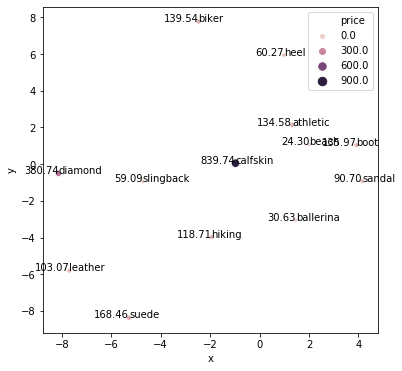

In [242]:
df_to_plot = pd.DataFrame({"x": x, "y": y, "price": prices, "word": subsample_words})

print(df_to_plot)

plt.figure(figsize=(6,6))

ax = sns.scatterplot(x="x", y="y",
                     hue="price", size="price",
                     data=df_to_plot)

for index, row in df_to_plot.iterrows():
    ax.text(row["x"], row["y"], row["word"], horizontalalignment='left', size='medium', color='black', weight='light')
    ax.text(row["x"], row["y"], "%.2f" % row["price"], horizontalalignment='right', size='medium', color='black', weight='light')

## Visualize Contextual Biases

In [300]:
def get_contextual_matrix(factor):
    i = menu_dataset_wholeseq.all_factors.index(factor)
    return Wc[i]

def get_word_embedding(word):
    i = subsample_words.index(word)
    return np.expand_dims(X[i], axis=0)    

matrix_boston  = get_contextual_matrix("boston")
matrix_chicago = get_contextual_matrix("chicago")
matrix_newyork = get_contextual_matrix("new-york")
matrix_pitts   = get_contextual_matrix("pittsburgh")

embed_lobster  = get_word_embedding("lobster")
embed_pizza    = get_word_embedding("pizza")

In [301]:
# lobster
boston_lobster = embed_lobster + embed_lobster.dot(matrix_boston)
X_new = np.append(X, boston_lobster, axis=0)

newyork_lobster  = embed_lobster + embed_lobster.dot(matrix_newyork)
X_new = np.append(X_new, newyork_lobster, axis=0)

chicago_lobster = embed_lobster + embed_lobster.dot(matrix_chicago)
X_new = np.append(X_new, chicago_lobster, axis=0)

# pizza

boston_pizza = embed_pizza + embed_pizza.dot(matrix_boston)
X_new = np.append(X_new, boston_pizza, axis=0)

pitts_pizza  = embed_pizza + embed_pizza.dot(matrix_pitts)
X_new = np.append(X_new, pitts_pizza, axis=0)

chicago_pizza   = embed_pizza + embed_pizza.dot(matrix_chicago)
X_new = np.append(X_new, chicago_pizza, axis=0)

print (X_new.shape)

# print ("lobster:", embed_lobster)
# print ("boston_lobster:", boston_lobster)
# print ("pitts_lobster:", pitts_lobster)

(2006, 128)


In [302]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

tsne_results = tsne.fit_transform(X_new)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2006 samples in 0.016s...
[t-SNE] Computed neighbors for 2006 samples in 0.765s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2006
[t-SNE] Computed conditional probabilities for sample 2000 / 2006
[t-SNE] Computed conditional probabilities for sample 2006 / 2006
[t-SNE] Mean sigma: 3.013976
[t-SNE] KL divergence after 250 iterations with early exaggeration: 118.219734
[t-SNE] KL divergence after 300 iterations: 5.041368


In [303]:
x = []
y = []
for point in tsne_results:
    x.append(point[0])
    y.append(point[1])


In [249]:
word_factor_price_med = pickle.load(open("../params/menu_word_factor_med_price.p", "rb"))
word_price_avg = pickle.load(open("../params/menu_word_avg_price.p", "rb"))

In [304]:
prices = []
for word in subsample_words:
    try:
        prices.append(word_price_avg[word])
    except:
        prices.append(None)

# "boston lobster", "pittsburg lobster", "chicago lobster", "boston pizza", "pittsburg pizza", "chicago pizza"
prices.append(word_factor_price_med[("lobster", "boston")])
prices.append(word_factor_price_med[("lobster", "new-york")])
prices.append(word_factor_price_med[("lobster", "chicago")])
prices.append(word_factor_price_med[("pizza", "boston")])
prices.append(word_factor_price_med[("pizza", "pittsburgh")])
prices.append(word_factor_price_med[("pizza", "chicago")])

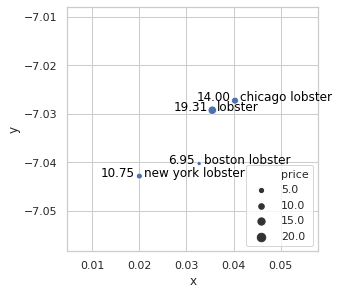

In [305]:
df_to_plot = pd.DataFrame({"x": x, "y": y, 
                           "word": subsample_words + ["boston lobster", "new york lobster", "chicago lobster", "boston pizza", "pittsburgh pizza", "chicago pizza"],
                           "price": prices})

plt.figure(figsize=(4.5,4.5))

df_to_plot = df_to_plot.loc[df_to_plot['word'].isin(["lobster", "boston lobster", "new york lobster", "chicago lobster"])]

ax = sns.scatterplot(x="x", y="y", size="price",
                     data=df_to_plot)

for index, row in df_to_plot.iterrows():
    ax.text(row["x"]+.001, row["y"], row["word"], horizontalalignment='left', size='medium', color='black', weight='light')
    ax.text(row["x"]-.001, row["y"], "%.2f" % row["price"], horizontalalignment='right', size='medium', color='black', weight='light')

plt.legend(loc='lower right')
    

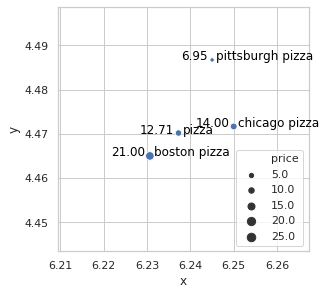

In [306]:
df_to_plot = pd.DataFrame({"x": x, "y": y, 
                           "word": subsample_words + ["boston lobster", "new york lobster", "chicago lobster", "boston pizza", "pittsburgh pizza", "chicago pizza"],
                           "price": prices})

plt.figure(figsize=(4.5,4.5))

df_to_plot = df_to_plot.loc[df_to_plot['word'].isin(["pizza", "boston pizza", "pittsburgh pizza", "chicago pizza"])]

ax = sns.scatterplot(x="x", y="y", size="price",
                     data=df_to_plot)

for index, row in df_to_plot.iterrows():
    ax.text(row["x"]+.001, row["y"], row["word"], horizontalalignment='left', size='medium', color='black', weight='light')
    ax.text(row["x"]-.001, row["y"], "%.2f" % row["price"], horizontalalignment='right', size='medium', color='black', weight='light')

plt.legend(loc='lower right')

### Shoes

In [245]:
dataset = "shoe"
model_name = "joint_wwm"
menu_fname = "shoe_price.csv"
encoding = "ISO-8859-1"

menu_frame = read_menu("../data/", menu_fname, encoding=encoding)

In [250]:
X_dict  = pickle.load(open("../trained_parameters/"+ model_name + "_" + dataset + "_X.p", "rb"))
Wc_dict = pickle.load(open("../trained_parameters/"+ model_name + "_" + dataset + "_Wc.p", "rb"))

In [251]:
all_words = [word for word in X_dict.keys()]
all_factors = [factor for factor in Wc_dict.keys()]

In [248]:
all_words.sort()

for word in all_words:
    print (word)

ab
abstract
ac
acacia
accent
ace
acorn
acrylic
action
active
ad
adjustable
adore
adult
afterward
air
alloy
almond
alpaca
alpine
amber
amuse
angel
angelfish
animal
ankle
another
apex
appeal
applause
aqua
arch
around
array
art
artisan
arty
ascent
ash
assert
assorted
athletic
authentic
autumn
available
away
baby
back
backless
badlands
bailey
balance
ballerina
ballet
ballistic
ballroom
bamboo
banana
band
banjo
bar
barb
bargain
bark
base
basic
basketball
batik
bay
beach
beacon
beaded
bee
beige
bell
belle
big
biggest
biker
bikers
bird
black
blazer
blemish
blend
block
blossom
blouse
blue
board
boat
bob
bone
bongo
boo
boost
boot
booty
bordello
born
bottom
bounce
bow
bowling
box
braided
brand
brass
bread
breathe
breeze
bright
bronze
brook
brown
buck
buckle
buckled
buffalo
bungee
burgundy
burlap
burnished
burst
butterfly
button
ca
cadet
cage
caged
caiman
calf
calfskin
cambric
camel
cameo
candy
canopy
canvas
cap
cape
cardigan
carol
cashmere
casual
cat
caterpillar
cave
champagne
charcoal
charisma


In [252]:
all_factors.sort()

for factor in all_factors:
    print (factor)

1 World Sarongs
143 GIRL
143 Girl
2 Lips Too
361
79 SCII
90 Degree by Reflex
A'rcopedico
A2 BY AEROSOLES
A2 By Aerosoles
A2 by Aerosoles
ADI
AGL
AMALFI BY RANGONI
ANNE KLEIN SPORT
ANTIGRAVITY BY EASY SPIRIT
ARIZONA JEAN COMPANY
AS By KSC
ASICS
Abound
Acacia
Academie Gear
Acorn
AdTec
Adam Tucker
Adidas
Adieu
Adriana
Adriana New York
Adrienne Vittadini
Aeropostale
Aerosoles
Ahnu
Alberto Fermini
Aldo
Alegria
Alexander McQueen
Alexander McQueen By Puma
Alexander Wang
Alexandre Birman
Alfani
Alice & Olivia
All Black
Allegra K
Alma Danza (X3 Series)
Alpine
Alpine Swiss
Altra Footwear
Amalfi By Rangoni
Amalfi by Rangoni
American Eagle
American Rag
Ami
AmoonyFashion
Anarchic By T.U.K.
Andre Assous
Andrew Geller
Andrew Stevens
Ann Creek
Ann Marino
Anna
Anne Klein
Anne Klein AK
Anne Klein Sport
Anne Michelle
Annie
Annie Shoes
Antelope
Antigravity By Easy Spirit
Antonio Melani
AnyWear
Anyi Lu
Anywear
Apex
Aquatalia
Ara
Aravon
Arche
Ariat
Arider
Arizona Jean Company
Array
Arturo Chiang
Ash
Ashko
A

In [286]:
matrix_amq      = np.asarray(Wc_dict["Stuart Weitzman"])
matrix_burberry = np.asarray(Wc_dict["Kate Spade"])
matrix_ck       = np.asarray(Wc_dict["Calvin Klein"])
matrix_nike     = np.asarray(Wc_dict["Nike"])
matrix_jc       = np.asarray(Wc_dict["Jimmy Choo"])
matrix_mizuno   = np.asarray(Wc_dict["Mizuno"])

embed_heel    = np.asarray(X_dict["heel"])
embed_sneaker = np.asarray(X_dict["sneaker"])

In [287]:
X = []
for word in X_dict:
    X.append(X_dict[word])

X = np.asarray(X)

In [288]:
print (X.shape)
print (amq_heel.shape)

(1000, 128)
(1, 128)


In [289]:
# heel
amq_heel = embed_heel + embed_heel.dot(matrix_amq)
amq_heel = np.expand_dims(amq_heel, axis=0)
X_new = np.append(X, amq_heel, axis=0)

burberry_heel  = embed_heel + embed_heel.dot(matrix_burberry)
burberry_heel = np.expand_dims(burberry_heel, axis=0)
X_new = np.append(X_new, burberry_heel, axis=0)

ck_heel = embed_heel + embed_heel.dot(matrix_ck)
ck_heel = np.expand_dims(ck_heel, axis=0)
X_new = np.append(X_new, ck_heel, axis=0)

# sneaker
amq_sneaker = embed_sneaker + embed_sneaker.dot(matrix_jc)
amq_sneaker = np.expand_dims(amq_sneaker, axis=0)
X_new = np.append(X_new, amq_sneaker, axis=0)

burberry_sneaker  = embed_sneaker + embed_sneaker.dot(matrix_mizuno)
burberry_sneaker = np.expand_dims(burberry_sneaker, axis=0)
X_new = np.append(X_new, burberry_sneaker, axis=0)

nike_sneaker   = embed_sneaker + embed_sneaker.dot(matrix_nike)
nike_sneaker = np.expand_dims(nike_sneaker, axis=0)
X_new = np.append(X_new, nike_sneaker, axis=0)

print (X_new.shape)

# print ("lobster:", embed_lobster)
# print ("boston_lobster:", boston_lobster)
# print ("pitts_lobster:", pitts_lobster)

(1006, 128)


In [290]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

tsne_results = tsne.fit_transform(X_new)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1006 samples in 0.002s...
[t-SNE] Computed neighbors for 1006 samples in 0.195s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1006
[t-SNE] Computed conditional probabilities for sample 1006 / 1006
[t-SNE] Mean sigma: 2.966426
[t-SNE] KL divergence after 250 iterations with early exaggeration: 91.819145
[t-SNE] KL divergence after 300 iterations: 3.111656


In [291]:
x = []
y = []
for point in tsne_results:
    x.append(point[0])
    y.append(point[1])


In [265]:
word_factor_price_med = pickle.load(open("../params/shoe_factor_word_med_price.p", "rb"))
word_price_avg = pickle.load(open("../params/shoe_word_avg_price.p", "rb"))

In [277]:
brands_tmp = []
for word, brand in word_factor_price_med:
    if word == "sneaker":
        brands_tmp.append(str(brand))

brands_tmp.sort()

for brand in brands_tmp:
    print (brand)

2 Lips Too
361
A'rcopedico
ASICS
Adidas
Aeropostale
Aerosoles
Ahnu
Aldo
Alexander McQueen
Alexander McQueen By Puma
American Rag
Aravon
Ash
Avia
Avon
BC
BCBG Max Azria
BP.
BSI
Balenciaga
Bebe Sport
Bettye Muller
Bloch
Blue
Bobs by Skechers
Bongo
Brinley Co.
CA by CINZIA ARAIA
CCILU
Calvin Klein
Calvin Klein CK
Carlos by Carlos Santana
Caterpillar
Christian Louboutin
Coach
Cobian
Cole Haan
Columbia
Comfy Feet
Converse
Cougar
Crocs
Cushe
DKNY
DUNHU
DV By Dolce Vita
Dance Class
Dansko
Diba
Dolce & Gabbana
Dolce Vita
Dolce by Mojo Moxy
Dr Scholls
Dr. Scholl's
Dr. Weil
Drew
Drew Shoe
EASY SPIRIT E360
ECCO
ED Ellen DeGeneres
Easy Spirit
Easy Spirit e360
Easy Street
Ed Hardy
Faded Glory
Fahrenheit
Feiyue.
Fendi
Fergalicious
Fila
Flexus by Spring Step
Fratelli Rossetti
G BY GUESS
Gabor
Generic Surplus
Giani Bernini
Giuseppe Zanotti
Givenchy
Gola
Golden Goose
Gotta Flurt
Gourmet
Grasshoppers
H by Halston
Helly Hansen
Hogan by Tod's
INC International Concepts
Impo
Isaac Mizrahi
JAMBU
JBU by Jamb

In [292]:
prices = []
for word in all_words:
    try:
        prices.append(word_price_avg[word])
    except:
        prices.append(None)

# "boston lobster", "pittsburg lobster", "chicago lobster", "boston pizza", "pittsburg pizza", "chicago pizza"
prices.append(word_factor_price_med[("heel", "Stuart Weitzman")])
prices.append(word_factor_price_med[("heel", "Kate Spade")])
prices.append(word_factor_price_med[("heel", "Calvin Klein")])
prices.append(word_factor_price_med[("sneaker", "Jimmy Choo")])
prices.append(word_factor_price_med[("sneaker", "Mizuno")])
prices.append(word_factor_price_med[("sneaker", "Nike")])

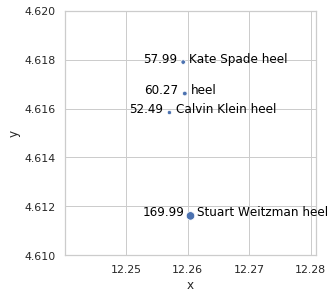

In [310]:
df_to_plot = pd.DataFrame({"x": x, "y": y, 
                           "word": all_words + ["Stuart Weitzman heel", "Kate Spade heel", "Calvin Klein heel", "Jimmy Choo sneaker", "Mizuno sneaker", "Nike sneaker"],
                           "price": prices})

plt.figure(figsize=(4.5,4.5))

df_to_plot = df_to_plot.loc[df_to_plot['word'].isin(["heel", "Stuart Weitzman heel", "Kate Spade heel", "Calvin Klein heel"])]

sns.set(style="whitegrid")
ax = sns.scatterplot(x="x", y="y", size="price",
                     data=df_to_plot)

for index, row in df_to_plot.iterrows():
    ax.text(row["x"]+.001, row["y"], row["word"], horizontalalignment='left', size='medium', color='black', weight='light')
    ax.text(row["x"]-.001, row["y"], "%.2f" % row["price"], horizontalalignment='right', size='medium', color='black', weight='light')

ax.set(ylim=(4.61, 4.62))
# plt.legend(loc='lower right')
ax.get_legend().remove()    

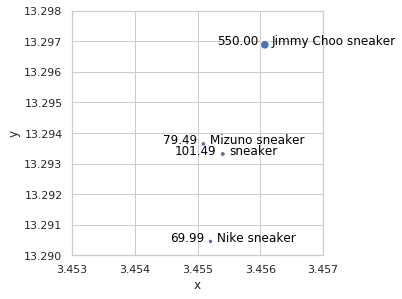

In [314]:
df_to_plot = pd.DataFrame({"x": x, "y": y, 
                           "word": all_words + ["Stuart Weitzman heel", "Kate Spade heel", "Calvin Klein heel", "Jimmy Choo sneaker", "Mizuno sneaker", "Nike sneaker"],
                           "price": prices})

plt.figure(figsize=(4.5,4.5))

df_to_plot = df_to_plot.loc[df_to_plot['word'].isin(["sneaker", "Jimmy Choo sneaker", "Mizuno sneaker", "Nike sneaker"])]

sns.set(style="whitegrid")
ax = sns.scatterplot(x="x", y="y", size="price",
                     data=df_to_plot)

for index, row in df_to_plot.iterrows():
    ax.text(row["x"]+.0001, row["y"], row["word"], horizontalalignment='left', size='medium', color='black', weight='light')
    ax.text(row["x"]-.0001, row["y"], "%.2f" % row["price"], horizontalalignment='right', size='medium', color='black', weight='light')

ax.set(xlim=(3.453, 3.457))
ax.set(ylim=(13.29, 13.298))
# plt.legend(loc='lower right')
ax.get_legend().remove()    